In [177]:
#!pip install yfinance pandas numpy statsmodels keras tensorflow

In [178]:
# trading_algo.py

import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from collections import defaultdict

In [179]:
def fetch_stock_data(ticker, start_date, end_date, interval='1d'):
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
        return stock_data['Close']
    except OverflowError:
        print(f"Overflow error fetching data for {ticker}.")
        return None
    except Exception as e:
        print(f"Error fetching data for {ticker}. Reason: {e}")
        return None

In [180]:
def moving_average_forecast(train_data, test_data, window_size=30):
    forecast_length = len(test_data)
    full_data_ma = train_data.rolling(window=window_size).mean()
    return full_data_ma[-forecast_length:]

In [181]:
def exponential_smoothing_forecast(train_data, test_data):
    forecast_length = len(test_data)
    model = ExponentialSmoothing(train_data)
    model_fit = model.fit()
    forecast = model_fit.predict(len(train_data), len(train_data) + forecast_length - 1)
    return forecast

In [182]:
def arima_forecast(train_data, test_data):
    forecast_length = len(test_data)
    # train_data.index = pd.DatetimeIndex(train_data.index).to_period('15T')
    model = ARIMA(train_data, order=(5,1,0))
    model_fit = model.fit()
    # forecast = model_fit.forecast(steps=forecast_length)[0]
    forecast = model_fit.predict(len(train_data), len(train_data) + forecast_length - 1)

    return forecast

In [183]:
def lstm_forecast(train_data, test_data):

    test_data_length = len(test_data)
    data = np.array(train_data).reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)


    # transform data for LSTM
    X, y = [], []
    for i in range(len(data)-1-1):
        X.append(data[i:(i+1), 0])
        y.append(data[i + 1, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))


    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=100, verbose=0)

    pred = model.predict(np.array([data[-test_data_length:]]).reshape(test_data_length,1,1))
    return pd.Series(scaler.inverse_transform(pred).flatten(), index=test_data.index)



In [184]:
def generate_signals(data, forecast):
    buy_signal = (data.shift(1) < forecast.shift(1)) & (data > forecast)
    sell_signal = (data.shift(1) > forecast.shift(1)) & (data < forecast)
    return buy_signal, sell_signal

In [185]:
def compute_metrics(true_data, predictions):
    # print(true_data)
    # print(predictions)
    mae = mean_absolute_error(true_data, predictions)
    rmse = np.sqrt(mean_squared_error(true_data, predictions))
    return mae, rmse


In [186]:
def plot_forecasts(ticker, data, forecasts, algorithm_name):
    plt.figure(figsize=(12,6))
    plt.plot(data, label='True Data')
    plt.plot(data.index[-len(forecasts):], forecasts, label=f'{algorithm_name} Forecast', alpha=0.7)
    plt.title(f'{ticker} Stock Prices and {algorithm_name} Forecasts')
    plt.legend()
    plt.show()

In [187]:
def trade(portfolio, ticker, data, forecast):
    trade_history = {'Date': [], 'Action': [], 'Portfolio Value': []}

    buy_signal, sell_signal = generate_signals(data, forecast)

    for date in data.index:
        if buy_signal[date]:
            portfolio[ticker]['shares'] += portfolio[ticker]['fund'] / data[date]
            portfolio[ticker]['fund'] -= portfolio[ticker]['fund'] / data[date] * data[date]
            trade_history['Date'].append(date)
            trade_history['Action'].append('Buy')
            trade_history['Portfolio Value'].append(portfolio[ticker]['fund'] + portfolio[ticker]['shares'] * data[date])
        elif sell_signal[date]:
            portfolio[ticker]['fund'] += portfolio[ticker]['shares'] * data[date]
            portfolio[ticker]['shares'] = 0
            trade_history['Date'].append(date)
            trade_history['Action'].append('Sell')
            trade_history['Portfolio Value'].append(portfolio[ticker]['fund'])

    return trade_history



In [188]:
def calculate_total_portfolio_value(portfolio):
    return sum([portfolio[ticker]['value'] for ticker in tickers])

In [189]:
def annualized_return(initial_value, final_value, period_in_years):
    return (final_value/initial_value)**(1/period_in_years) - 1

In [190]:
def sharpe_ratio(returns, risk_free_rate=0.03):
    return (np.mean(returns) - risk_free_rate) / np.std(returns)

In [191]:
def calculate_portfolio_value(portfolio, data):
    total_value = 0
    for ticker in tickers:
        total_value += portfolio[ticker]['shares'] * data[ticker].iloc[-1]
        total_value += portfolio[ticker]['fund']
    return total_value


Processing DIS...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Running Moving Average...


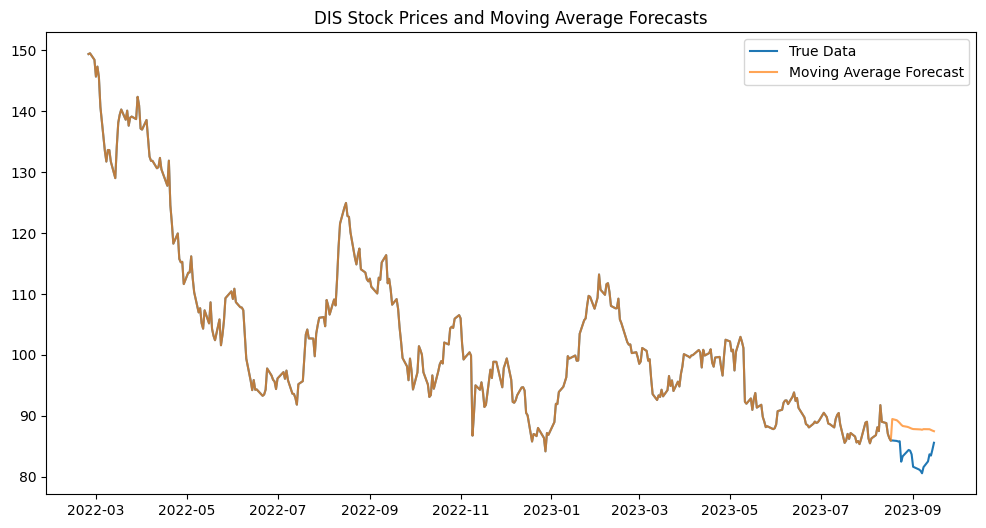

Moving Average - MAE: 4.578098475138347, RMSE: 4.802598046174132
Running Exponential Smoothing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


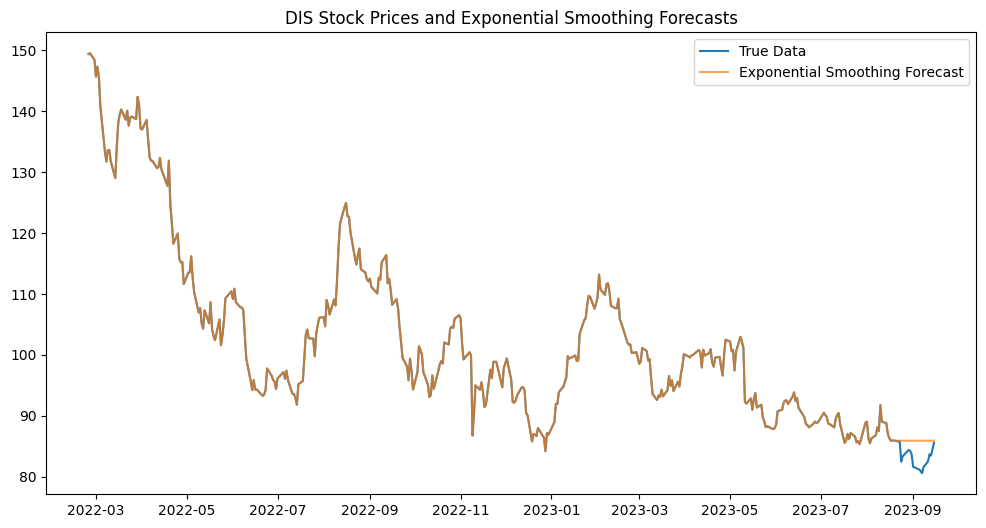

Exponential Smoothing - MAE: 2.3484973965138236, RMSE: 2.905792770678103
Running ARIMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

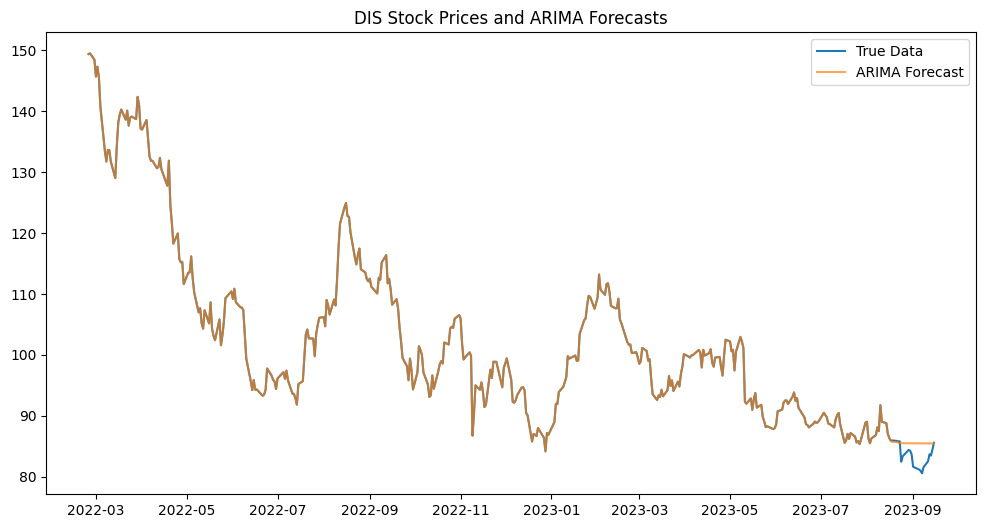

ARIMA - MAE: 2.0409562124764826, RMSE: 2.562417330175123
Running LSTM...
1/1 [==============================] - 0s 302ms/step


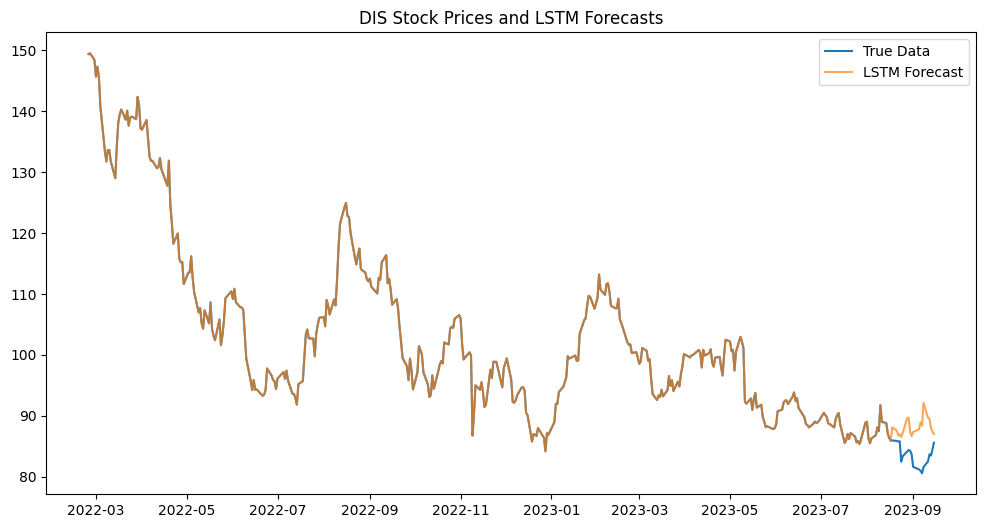

LSTM - MAE: 4.556488418579102, RMSE: 5.221667053874773
Processing AMZN...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Running Moving Average...


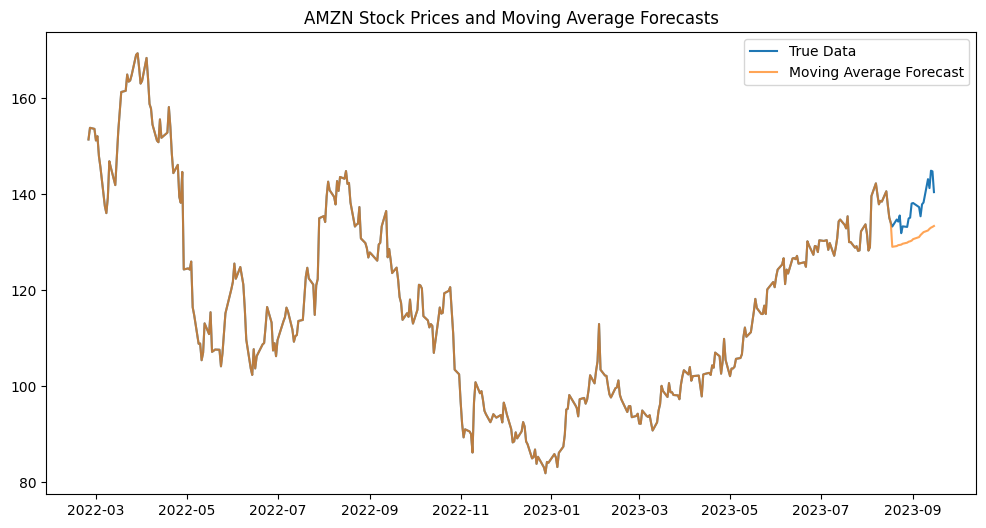

Moving Average - MAE: 6.3612329991658525, RMSE: 6.871456914246128
Running Exponential Smoothing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


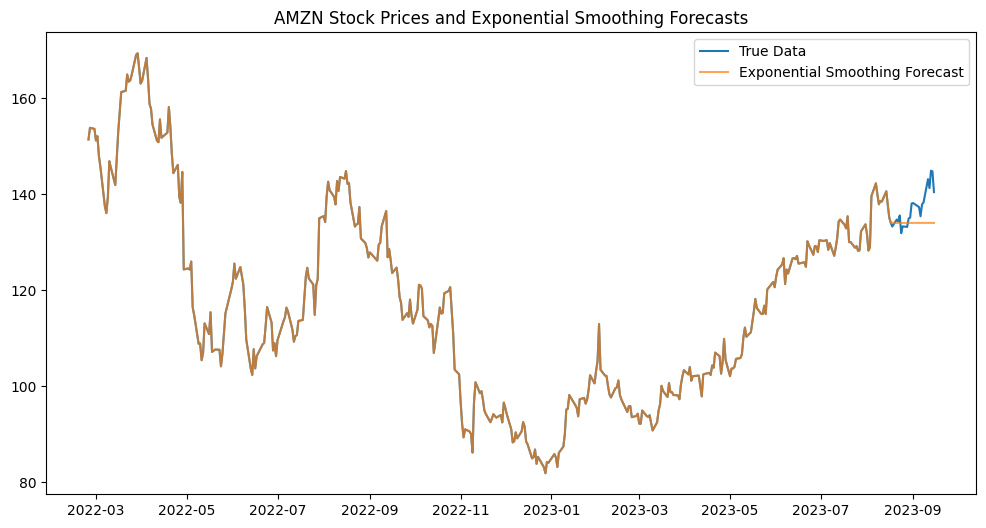

Exponential Smoothing - MAE: 3.7170036218463336, RMSE: 5.004235015483724
Running ARIMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

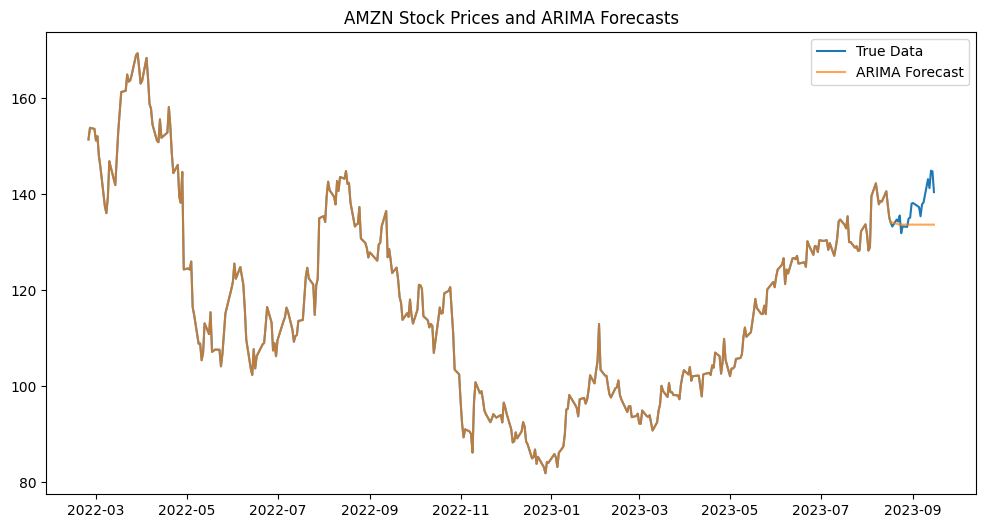

ARIMA - MAE: 3.9472832472264643, RMSE: 5.250086149576975
Running LSTM...
1/1 [==============================] - 0s 450ms/step


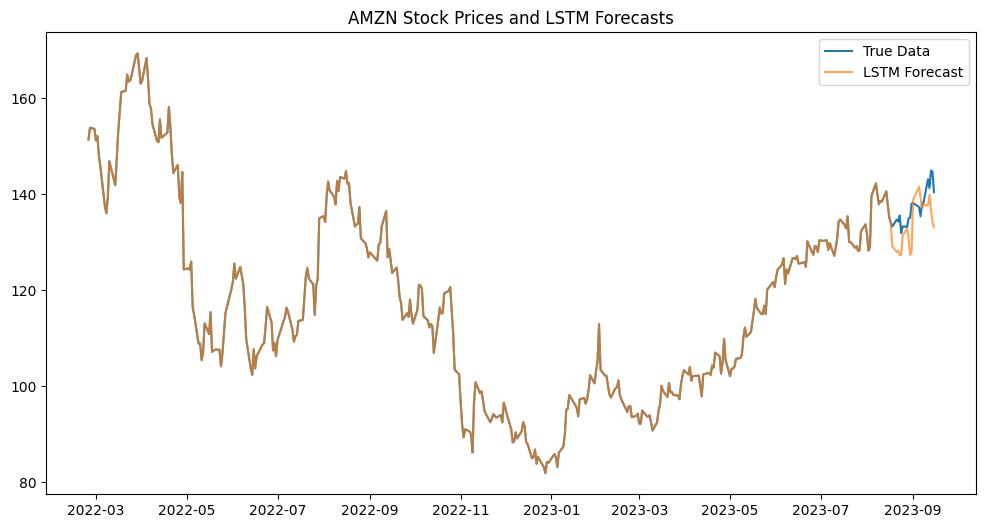

LSTM - MAE: 4.834249877929688, RMSE: 5.761731247993932
Processing LULU...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Running Moving Average...


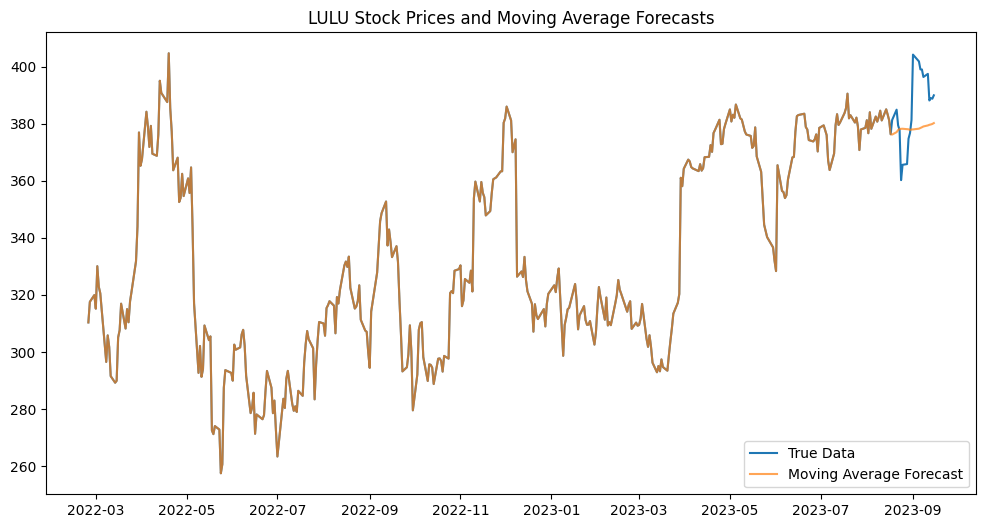

Moving Average - MAE: 11.391632130940755, RMSE: 13.743427156864543
Running Exponential Smoothing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


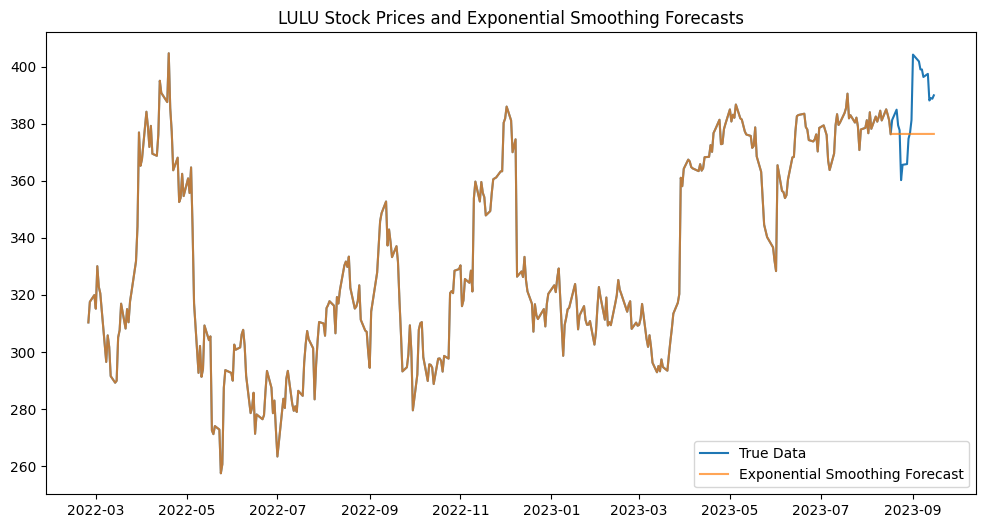

Exponential Smoothing - MAE: 12.582332735848444, RMSE: 15.055759886489104
Running ARIMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

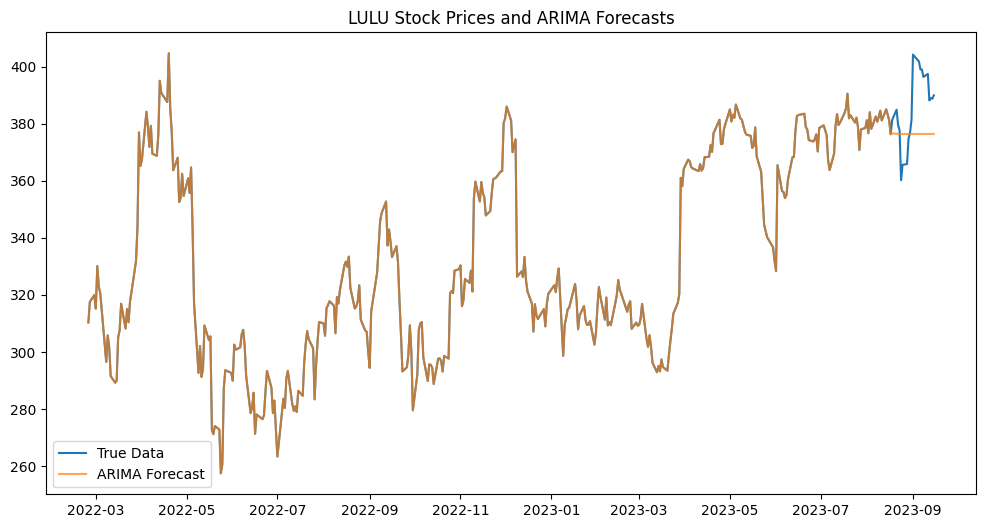

ARIMA - MAE: 12.578650227021791, RMSE: 15.059763205910961
Running LSTM...
1/1 [==============================] - 0s 319ms/step


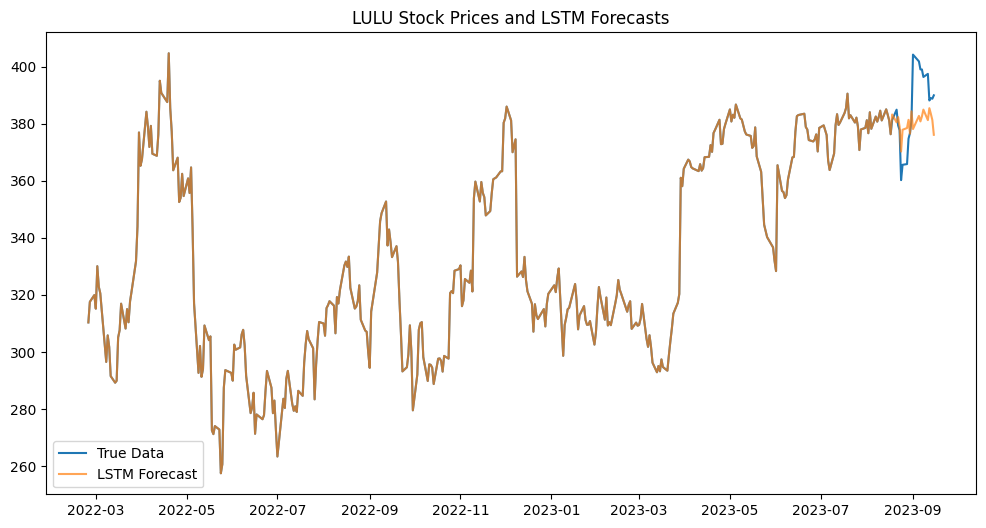

LSTM - MAE: 9.61524658203125, RMSE: 11.876507975589345
Processing TSLA...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Running Moving Average...


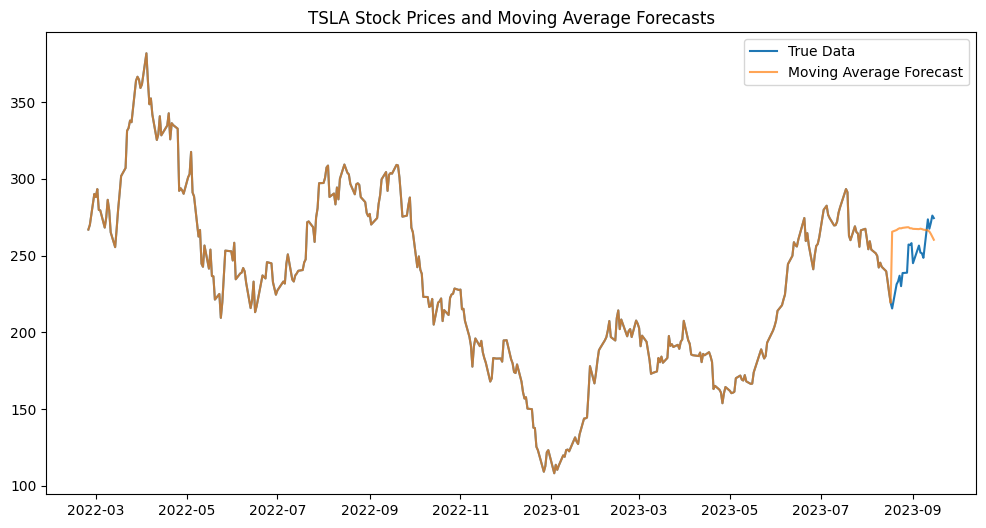

Moving Average - MAE: 20.298635330200195, RMSE: 23.787477829025033
Running Exponential Smoothing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


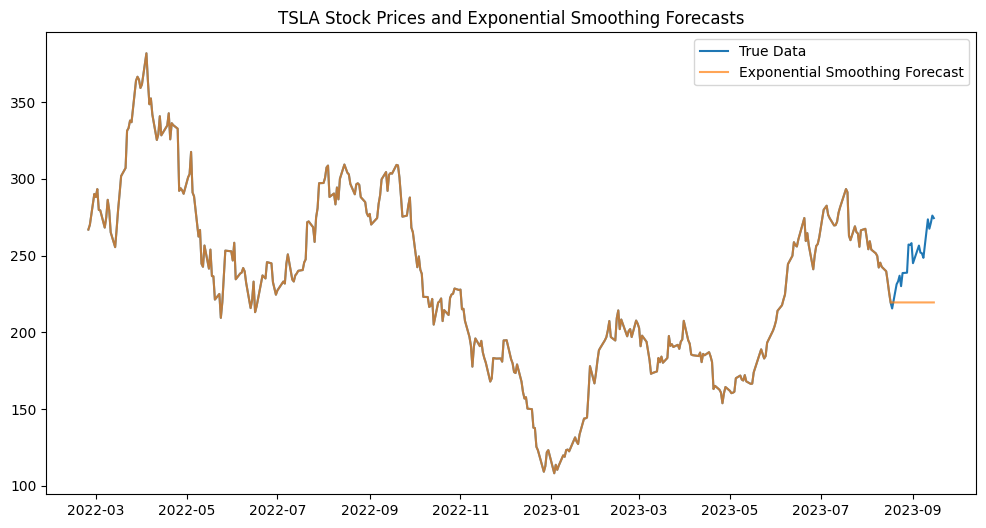

Exponential Smoothing - MAE: 31.58375122105135, RMSE: 35.30186973375507
Running ARIMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

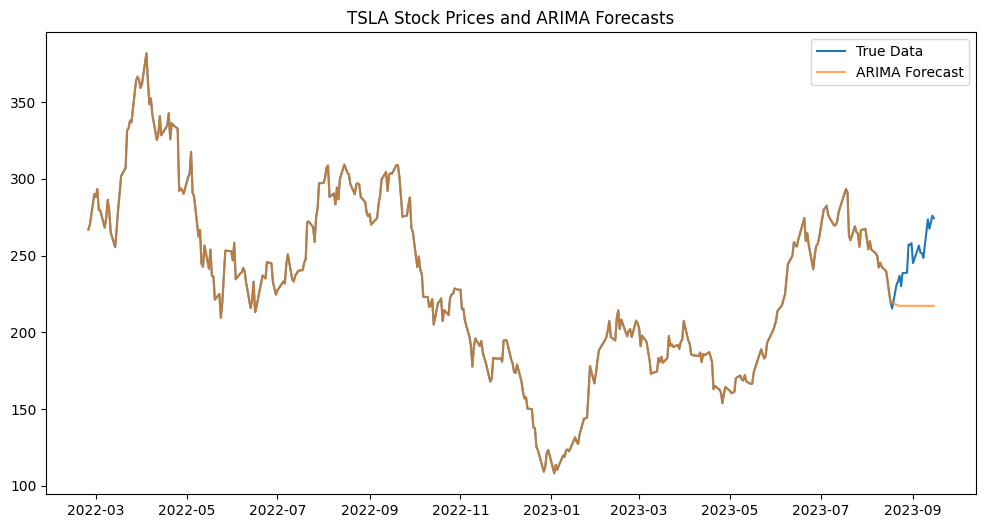

ARIMA - MAE: 33.61562218709747, RMSE: 37.27008910763978
Running LSTM...
1/1 [==============================] - 0s 309ms/step


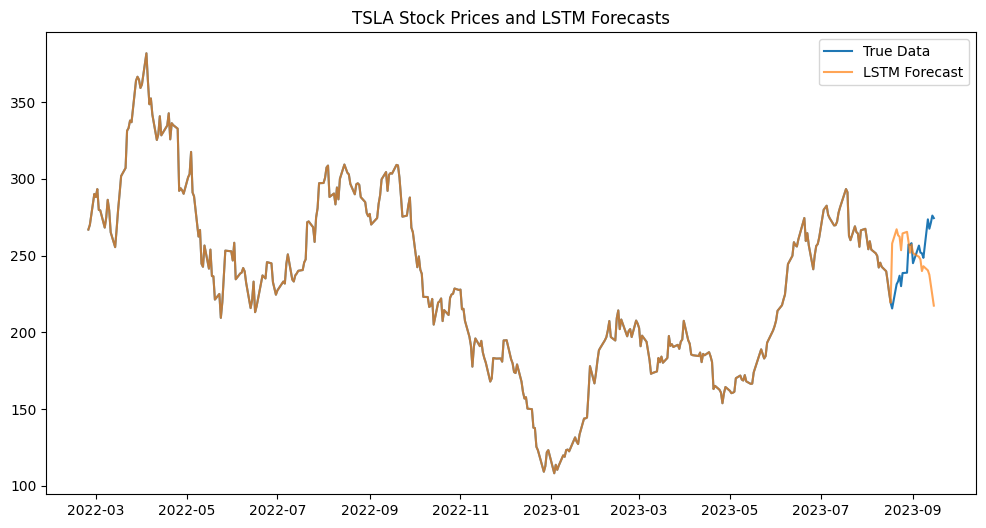

LSTM - MAE: 23.305269622802733, RMSE: 28.742426218495023
Processing AAPL...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Running Moving Average...


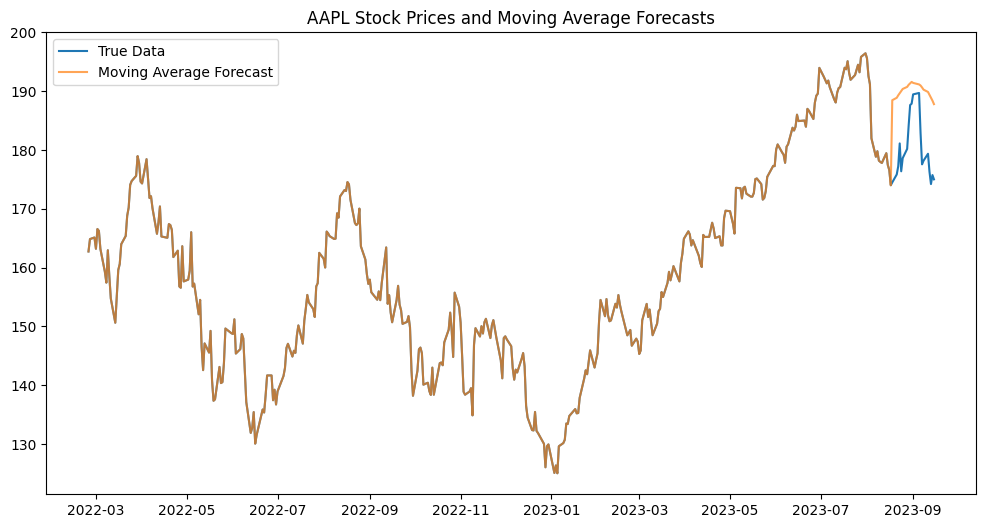

Moving Average - MAE: 9.91368408203125, RMSE: 10.73300264806408
Running Exponential Smoothing...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


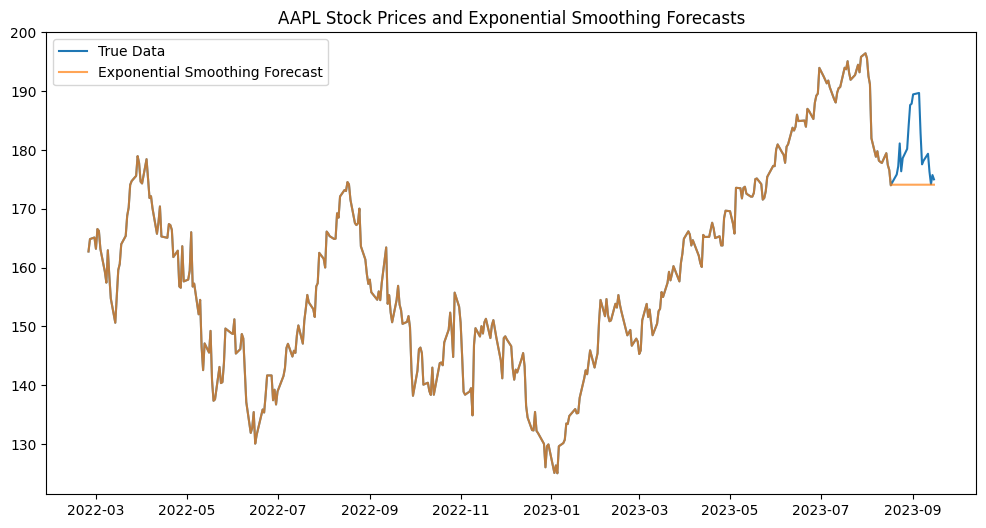

Exponential Smoothing - MAE: 5.998646422532926, RMSE: 7.812090645775541
Running ARIMA...


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

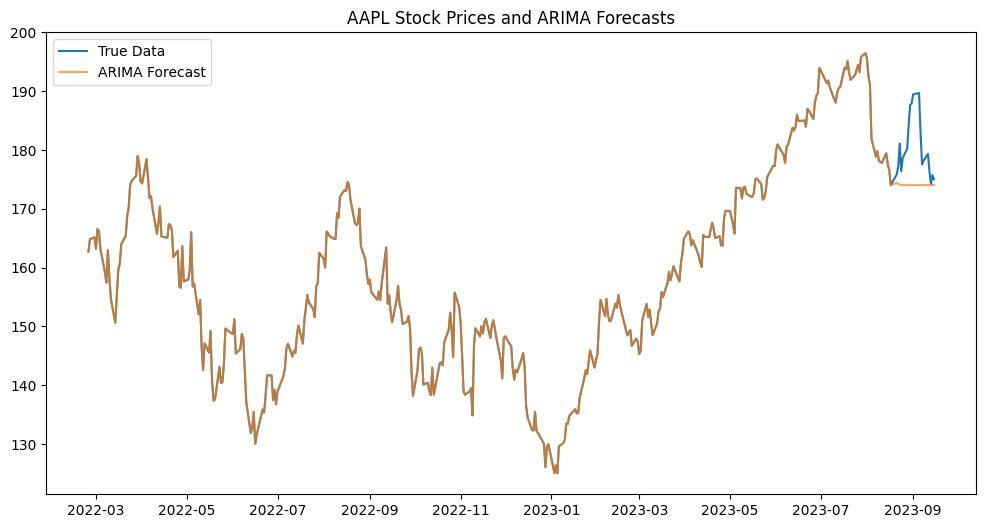

ARIMA - MAE: 6.022650895323563, RMSE: 7.845920536227735
Running LSTM...
1/1 [==============================] - 0s 314ms/step


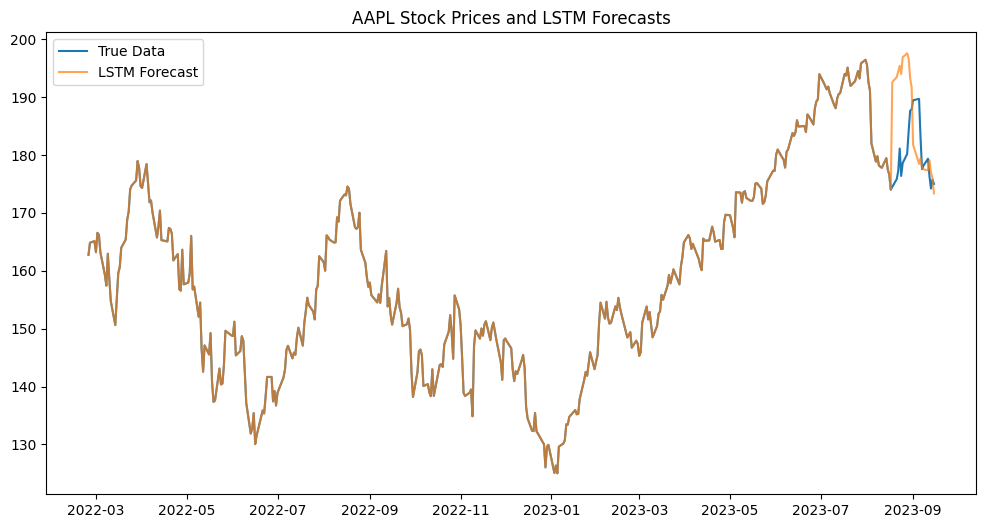

LSTM - MAE: 8.762277221679687, RMSE: 11.197213214917628


In [170]:
# if __name__ == '__main__':
tickers = ["DIS", "AMZN", "LULU", "TSLA", "AAPL"]
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

# Day Trader
# # From current date, go back 1 week for test start date
# test_start_date = (datetime.datetime.now() - datetime.timedelta(weeks=1)).strftime('%Y-%m-%d')

# # From test start date, go back 3 weeks for training start date
# train_start_date = (datetime.datetime.strptime(test_start_date, '%Y-%m-%d') - datetime.timedelta(weeks=3)).strftime('%Y-%m-%d')

# Long Trader
# From current date, go back 1 month for test start date
test_start_date = (datetime.datetime.now() - datetime.timedelta(days=30)).strftime('%Y-%m-%d')

# From test start date, go back 11 months for training start date
train_start_date = (datetime.datetime.strptime(test_start_date, '%Y-%m-%d') - datetime.timedelta(days=30*18)).strftime('%Y-%m-%d')

model_performance = defaultdict(list)
for ticker in tickers:
    print(f"Processing {ticker}...")

    train_data = fetch_stock_data(ticker, train_start_date, test_start_date)
    test_data = fetch_stock_data(ticker, test_start_date, end_date)

    algorithms = {
        'Moving Average': moving_average_forecast,
        'Exponential Smoothing': exponential_smoothing_forecast,
        'ARIMA': arima_forecast,
        'LSTM': lstm_forecast
    }

    for algo_name, algo_func in algorithms.items():
        print(f"Running {algo_name}...")
        forecast = algo_func(train_data, test_data)

        mae, rmse = compute_metrics(test_data, forecast)
        model_performance[algo_name].append((mae, rmse))
        plot_forecasts(ticker, pd.concat([train_data, test_data]), pd.concat([train_data, forecast]), algo_name)

        print(f"{algo_name} - MAE: {mae}, RMSE: {rmse}")


In [171]:
model_performance

defaultdict(list,
            {'Moving Average': [(4.578098475138347, 4.802598046174132),
              (6.3612329991658525, 6.871456914246128),
              (11.391632130940755, 13.743427156864543),
              (20.298635330200195, 23.787477829025033),
              (9.91368408203125, 10.73300264806408)],
             'Exponential Smoothing': [(2.3484973965138236, 2.905792770678103),
              (3.7170036218463336, 5.004235015483724),
              (12.582332735848444, 15.055759886489104),
              (31.58375122105135, 35.30186973375507),
              (5.998646422532926, 7.812090645775541)],
             'ARIMA': [(2.0409562124764826, 2.562417330175123),
              (3.9472832472264643, 5.250086149576975),
              (12.578650227021791, 15.059763205910961),
              (33.61562218709747, 37.27008910763978),
              (6.022650895323563, 7.845920536227735)],
             'LSTM': [(4.556488418579102, 5.221667053874773),
              (4.834249877929688, 5.7617312

In [172]:
algo_summary = {}
for k, v in model_performance.items():
  algo_summary[k] = [[tup[0] for tup in v],[tup[1] for tup in v]]
for k, v in algo_summary.items():
  algo_summary[k] = [np.average(v[0]),np.average(v[1])]
pd.DataFrame.from_dict(algo_summary).rename(index={0:'MAE',1:'RMSE'})

,Moving Average,Exponential Smoothing,ARIMA,LSTM
MAE,10.508657,11.246046,11.641033,10.214706
RMSE,11.987593,13.215950,13.597655,12.559909


In [173]:
# Initialize the portfolio

initial_investment = 100000  # For example
initial_fund_per_stock = initial_investment / len(tickers)

portfolio = {}
for ticker in tickers:
    portfolio[ticker] = {
        'fund': initial_fund_per_stock,
        'shares': 0,
        'value': initial_fund_per_stock
    }

Processing DIS...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Trading based on LSTM for DIS...
1/1 [==============================] - 0s 310ms/step


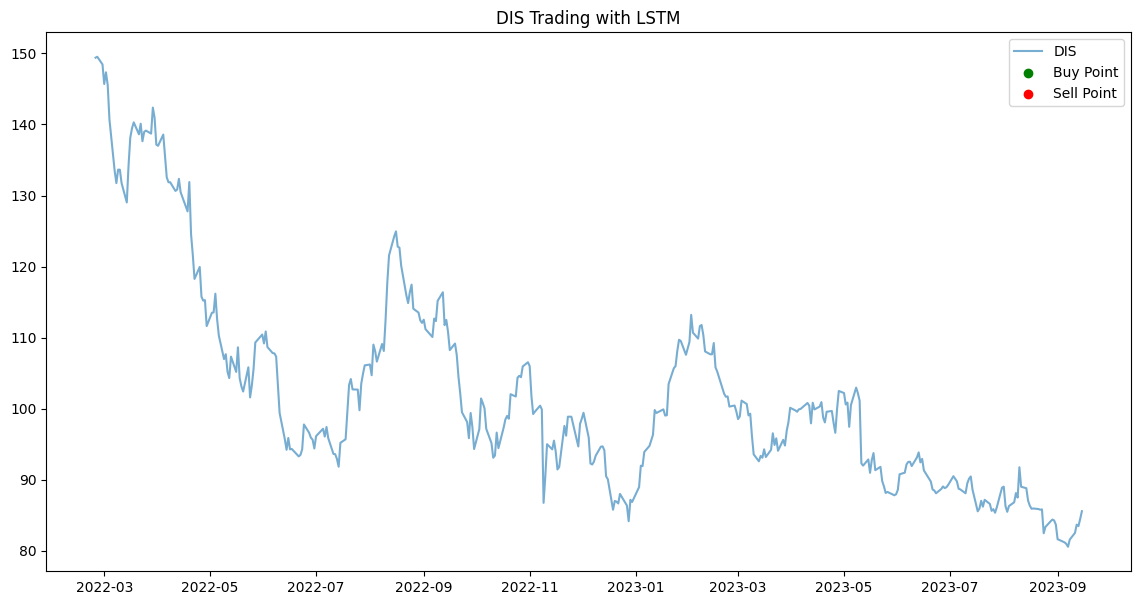

Processing AMZN...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Trading based on LSTM for AMZN...
1/1 [==============================] - 0s 323ms/step


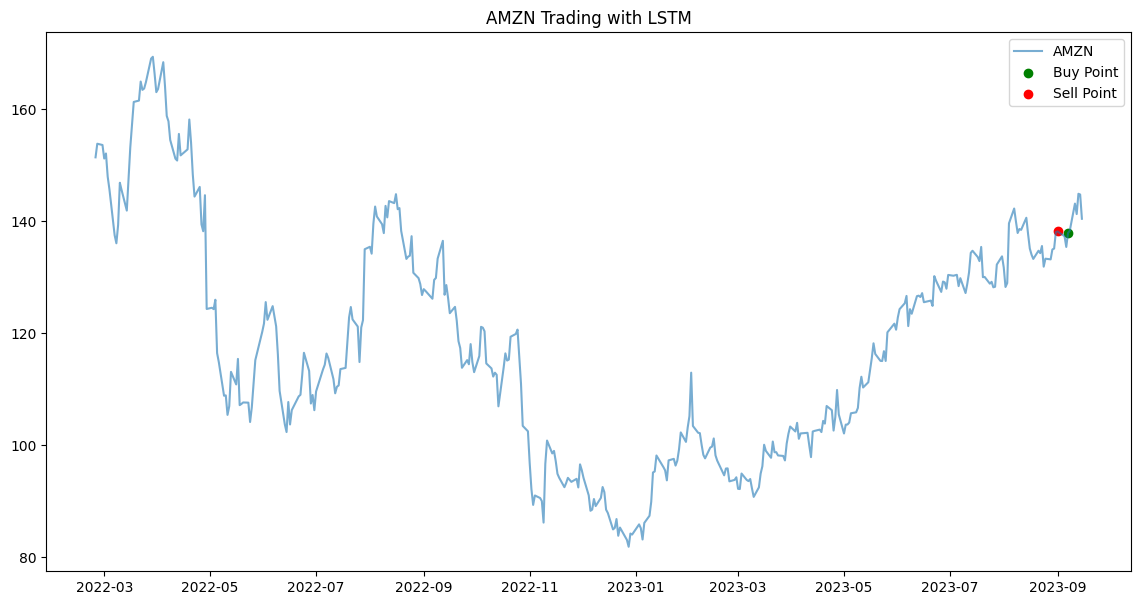

Processing LULU...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Trading based on LSTM for LULU...
1/1 [==============================] - 0s 319ms/step


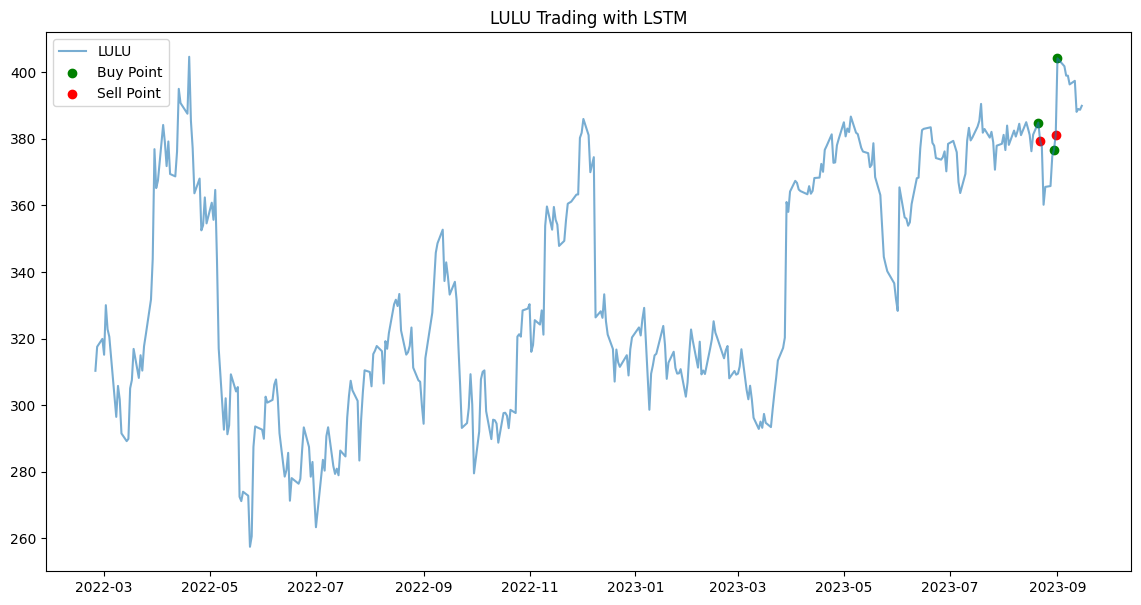

Processing TSLA...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Trading based on LSTM for TSLA...
1/1 [==============================] - 0s 299ms/step


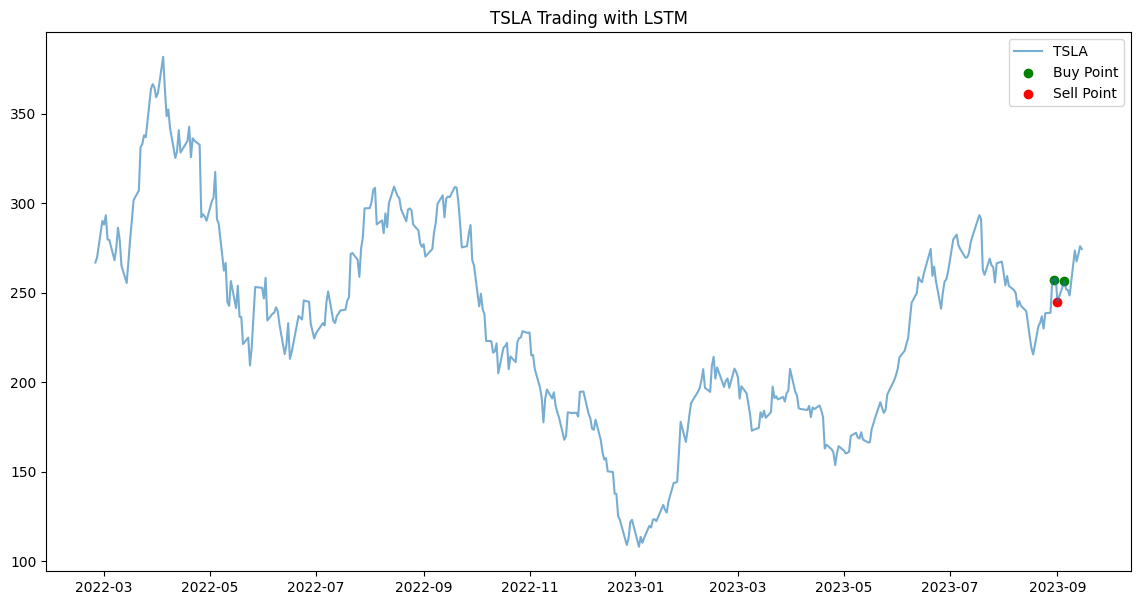

Processing AAPL...
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Trading based on LSTM for AAPL...
1/1 [==============================] - 0s 284ms/step


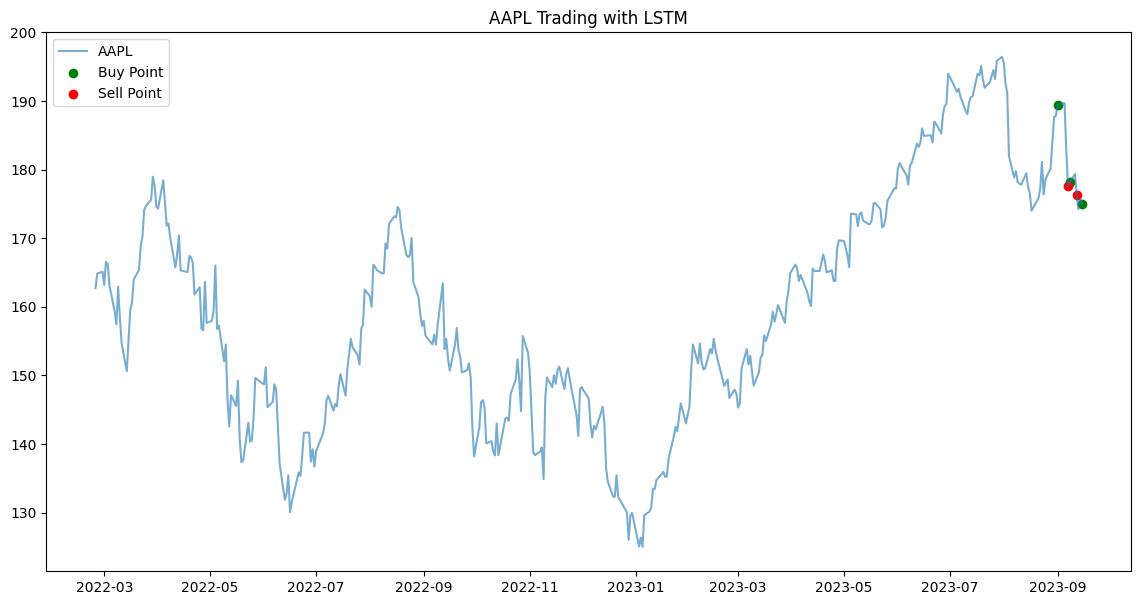

In [174]:
for ticker in tickers:
    print(f"Processing {ticker}...")

    train_data = fetch_stock_data(ticker, train_start_date, test_start_date)
    test_data = fetch_stock_data(ticker, test_start_date, end_date)

    # Use LSTM's forecast for the trading logic
    print(f"Trading based on LSTM for {ticker}...")
    lstm_forecast_values = lstm_forecast(train_data, test_data)
    trade_hist = trade(portfolio, ticker, pd.concat([train_data, test_data]), pd.concat([train_data, lstm_forecast_values]))

    # Visualize trade history
    plt.figure(figsize=(14, 7))
    plt.plot(pd.concat([train_data, test_data]), label=ticker, alpha=0.6)

    buy_dates = [date for i, date in enumerate(trade_hist['Date']) if trade_hist['Action'][i] == 'Buy']
    buy_values = [pd.concat([train_data, test_data])[date] for date in buy_dates]
    sell_dates = [date for i, date in enumerate(trade_hist['Date']) if trade_hist['Action'][i] == 'Sell']
    sell_values = [pd.concat([train_data, test_data])[date] for date in sell_dates]

    plt.scatter(buy_dates, buy_values, color='g', label='Buy Point')
    plt.scatter(sell_dates, sell_values, color='r', label='Sell Point')
    plt.title(f"{ticker} Trading with LSTM")
    plt.legend()
    plt.show()


In [175]:
# Performance Metrics
final_portfolio_value = calculate_total_portfolio_value(portfolio)
print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")

period_in_years = (datetime.datetime.now() - datetime.datetime.strptime(train_start_date, '%Y-%m-%d')).days / 365.25
ann_return = annualized_return(initial_investment, final_portfolio_value, period_in_years)
print(f"Annualized Return: {ann_return*100:.2f}%")

daily_returns = pd.concat([train_data, test_data]).pct_change().dropna()
s_ratio = sharpe_ratio(daily_returns)
print(f"Sharpe Ratio: {s_ratio:.2f}")

Final Portfolio Value: $100000.00
Annualized Return: 0.00%
Sharpe Ratio: -1.53


In [176]:
portfolio

{'DIS': {'fund': 20000.0, 'shares': 0, 'value': 20000.0},
 'AMZN': {'fund': 0.0, 'shares': 145.0852311532102, 'value': 20000.0},
 'LULU': {'fund': 0.0, 'shares': 49.363710401608955, 'value': 20000.0},
 'TSLA': {'fund': 0.0, 'shares': 74.36683202889871, 'value': 20000.0},
 'AAPL': {'fund': 0.0, 'shares': 105.9712627935134, 'value': 20000.0}}